In [2]:
import tensorflow as tf
from tensorflow import keras
from skimage import io
from skimage.io import imread_collection
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import requests
import shutil

## Fetch Data (Images)
We begin by fetching a dataset of 10,000 images from [thispersondoesnotexistcom](https://www.thispersondoesnotexist.com). We do so by requesting from the endpoint `thispersondoesnotexist.com/images` 10,000 (k) times.

In [3]:
def fetch_images(k: int, folder_name: str):
    """ 
    Fetch images from thispersondoesnotexist.com
    
    :param k: number of images to fetch
    :param folder_name: name of folder to save images to
    """
    if k < 1:
        return 0
    
    # Locals
    count = 0
    endpoint = 'image'
    url = f'https://thispersondoesnotexist.com/{endpoint}'
    while count < k:
        image = requests.get(url).content
        with open(f'{folder_name}/img_{count}.png', 'wb') as f:
            f.write(image)
        count += 1
        
        # A times.sleep(x) is recommended to avoid latency errors

We can now call this function and store the images locally

```python
fetch_images(k=10_000, folder_name='images')
```

## Validating image
We should validate wether the image exists

In [4]:
def image_exists(folder_name:str) -> bool:
    """ 
    Check whether an image exists in folder_name
    
    :param folder_name: folder in which dataset images are located
    """
    try:
        # Default image 0
        image = io.imread(f'{folder_name}/img_0.png')
        return (True, image)
    except:
        print(f'Image "img_0.png" in {folder_name} not found')
        return False

## Showing a batch
We can see a random batch of images from the dataset

In [5]:
def show_batch(batch):
    images = np.random.randint(low=0, high=len(batch), size=16) # get random indices
    fig = plt.figure(figsize= (4, 4)) 
    fig, axs = plt.subplots(4,4, sharex=True, sharey=True)
    cnt = 0 
    for i in range(4):
        for j in range(4):
            axs[i, j].imshow(batch[images[cnt]]) # get image from batch at index 'i'
            cnt += 1
    plt.show()

### Image Attributes

In [6]:
def img_attr(batch):
    print(f'Images are {batch[0].shape[0]} by {batch[0].shape[1]} with {batch[0].shape[2]} channels')

---

Retreive all images from dataset

In [7]:
collection = imread_collection("./images/*.png")

In [8]:
len(collection)

10000

<Figure size 288x288 with 0 Axes>

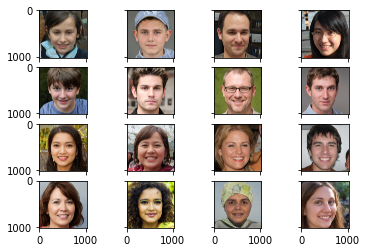

In [9]:
show_batch(collection)

In [10]:
collection[0].shape

(1024, 1024, 3)

In [11]:
img_attr(collection)

Images are 1024 by 1024 with 3 channels


### Neural Network - 1.0
We begin by definning attributes. All images in the dataset are from [thispersondoesnotexistcom](https://www.thispersondoesnotexist.com), therefore all images are $1024 \times 1024$ with $3$ channels

In [12]:
rows = collection[0].shape[0]
cols = collection[0].shape[1]
channels = collection[0].shape[2]

In [13]:
image_shape = (rows, cols, channels)

`z_dim` represents the dimenions of the noise vector to be inputed into the generator

We first import libraries to be used

In [14]:
from keras.layers import Dense, Flatten, Reshape, Conv2DTranspose, UpSampling2D, Activation, Conv2D, BatchNormalization, UpSampling2D
from keras.layers import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam

In [15]:
z_dim = 512 # 512 is a good default

We implement the schematics for $G(z)$ to generate $1024 \times 1024$ images from [Marchesi, Marco. (2017). Megapixel Size Image Creation using Generative Adversarial Networks.](https://www.researchgate.net/publication/317300265_Megapixel_Size_Image_Creation_using_Generative_Adversarial_Networks), [Karras, Aila. (2018). Progressive Growing of GANs for Improved Quality Stability, and Variation.](https://arxiv.org/pdf/1710.10196.pdf)

#### Generator 

In [16]:
def create_generator(z):
    model = Sequential()
    
    # Input Latent vector
    model.add(Dense(512, input_dim=z))
    model.add(Reshape((1, 1, 512)))
    
    # Conv 1.0 (4x4) -> LeakyReLU -> (3x3) -> LeakyReLU
    model.add(Conv2DTranspose(512, kernel_size=4, padding='valid'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2DTranspose(512, kernel_size=3, padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    
    # Conv 2.0 (3x3) -> LeakyReLU -> (3x3) -> LeakyReLU
    model.add(Conv2DTranspose(512, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2DTranspose(512, kernel_size=3, padding='same')) 
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    
    # Conv 3.0 (3x3) -> LeakyReLU -> (3x3) -> LeakyReLU
    model.add(Conv2DTranspose(512, kernel_size=3, strides=2, padding='same')) 
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2DTranspose(512, kernel_size=3, padding='same')) 
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    
    # Conv 4.0 (3x3) -> LeakyReLU -> (3x3) -> LeakyReLU
    model.add(Conv2DTranspose(512, kernel_size=3, strides=2, padding='same')) 
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2DTranspose(512, kernel_size=3, padding='same')) 
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    
    # Conv 5.0 (3x3) -> LeakyReLU -> (3x3) -> LeakyReLU
    model.add(Conv2DTranspose(512, kernel_size=3, strides=2, padding='same')) 
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2DTranspose(512, kernel_size=3, padding='same')) 
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    
    # Conv 6.0 (3x3) -> LeakyReLU -> (3x3) -> LeakyReLU
    model.add(Conv2DTranspose(256, kernel_size=3, padding='same')) 
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2DTranspose(256, kernel_size=3, padding='same')) 
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    
    # Conv 7.0 (3x3) -> LeakyReLU -> (3x3) -> LeakyReLU
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')) 
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2DTranspose(128, kernel_size=3, padding='same')) 
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    
    # Conv 8.0 (3x3) -> LeakyReLU -> (3x3) -> LeakyReLU
    model.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding='same')) 
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2DTranspose(64, kernel_size=3, padding='same')) 
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    
    # Conv 9.0 (3x3) -> LeakyReLU -> (3x3) -> LeakyReLU
    model.add(Conv2DTranspose(32, kernel_size=3, strides=2, padding='same')) 
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2DTranspose(32, kernel_size=3, padding='same')) 
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    
    # Conv 10.0 (3x3) -> LeakyReLU -> (3x3) -> LeakyReLU
    model.add(Conv2DTranspose(16, kernel_size=3, strides=2, padding='same')) 
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2DTranspose(16, kernel_size=3, padding='same')) 
    model.add(LeakyReLU(alpha=0.1))
    model.add(Conv2DTranspose(3, kernel_size=1, padding='valid')) 
    model.add(LeakyReLU(alpha=0.1))
    model.add(Activation('tanh'))
    return model

In [17]:
def test_gen(z):
    gen = create_generator(z)
    noise = tf.random.normal([1, 512],)
    img = gen(noise, training=False)
    img = tf.reshape(img, shape=(img.shape[1], img.shape[2], img.shape[3]))
    plt.imshow(img)
    plt.show()

2023-02-22 10:17:02.122456: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


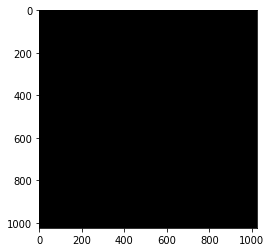

In [18]:
test_gen(z=z_dim)

#### Discriminator

In [19]:
def create_discriminator(img_shape):
    model = Sequential()
    model.add(Conv2D(16, kernel_size=1, padding='same', input_shape=img_shape))
    model.add(Conv2D(16, kernel_size=3, padding='same', input_shape=img_shape))
    model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', input_shape=img_shape))
    
    # Conv 2.0
    model.add(Conv2D(32, kernel_size=3, padding='same', input_shape=img_shape))
    model.add(Conv2D(64, kernel_size=2, strides=2, padding='valid', input_shape=img_shape))
    
    # Conv 3.0
    model.add(Conv2D(64, kernel_size=3, padding='same', input_shape=img_shape))
    model.add(Conv2D(128, kernel_size=2, strides=2, padding='valid', input_shape=img_shape))
    
    # Conv 4.0
    model.add(Conv2D(256, kernel_size=3, padding='same', input_shape=img_shape))
    model.add(Conv2D(256, kernel_size=2, strides=2, padding='valid', input_shape=img_shape))
    
    # Conv 5.0
    model.add(Conv2D(512, kernel_size=3, padding='same', input_shape=img_shape))
    model.add(Conv2D(512, kernel_size=2, strides=2, padding='valid', input_shape=img_shape))
    
    # Conv 6.0
    model.add(Conv2D(512, kernel_size=3, padding='same', input_shape=img_shape))
    model.add(Conv2D(512, kernel_size=2, strides=2, padding='valid', input_shape=img_shape))
    
    # Conv 7.0
    model.add(Conv2D(512, kernel_size=3, padding='same', input_shape=img_shape))
    model.add(Conv2D(512, kernel_size=2, strides=2, padding='valid', input_shape=img_shape))
    
    # Conv 8.0
    model.add(Conv2D(512, kernel_size=3, padding='same', input_shape=img_shape))
    model.add(Conv2D(512, kernel_size=2, strides=2, padding='valid', input_shape=img_shape))
    
    # Final 
    model.add(Conv2D(512, kernel_size=3, padding='same', input_shape=img_shape))
    model.add(Conv2D(512, kernel_size=3, strides=2, padding='valid', input_shape=img_shape))
    
    # Finalized
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    return model

#### Set up (S) - 1.1 Create
We begin by initializing the discriminator and generator

In [20]:
generator = create_generator(z=z_dim)
discriminator = create_discriminator(img_shape=image_shape)

#### S - 1.2 Compile 
We know compile both models. <br>
NOTE: _Implement OS exisitng model loading_

##### Generator Compile

In [21]:
generator.compile(loss='binary_crossentropy', 
                  optimizer=Adam())

##### Discriminator Compile

In [22]:
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

#### S - 1.3 Disable Discriminator Training

In [23]:
discriminator.trainable = False

In [24]:
def GAN(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    
    return model

In [25]:
gan = GAN(generator, discriminator)
gan.compile(loss='binary_crossentropy', 
                  optimizer=Adam())

#### TESTING DISC
---
```python
noise = tf.random.normal([1, 512],)
img = generator(noise, training=False)
disc_output = discriminator(img, training=False)
print("Discriminator output on fake images:", disc_output.numpy())
real_image = collection[0]
disc_2_output = discriminator(np.expand_dims(real_image, axis=0), training=False)
```
---

#### S - 1.4 Training Iterations

#### S - 1.4.1 Params

In [26]:
iterations = 10_000
batch_size = 32
sample_interval = 500

In [31]:
def train_gan(iteraions:int, batch_size:int, sample_interval:int):
    collection = imread_collection("./images/*.png")
    image_count = 0
    
    # Collect batch
    real_image_batch = np.array(collection[:sample_interval]) # get batch
    real_image_batch = np.array(collection[:sample_interval]) / 127.5 - 1.0 # rescale [-1,1]
    print(f'Collecting real images... Normalizing...')
    
    # Labels 
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))
    print(f'Generating labels ...')
    
    # Training
    for iteration in range(iterations):
        print(f'Iteration {iteration} of {iteraions} - New Process')
        
        # Random batch of real images
        batch_of_real_indecies = np.random.randint(0, real_image_batch.shape[0], batch_size)
        batch_of_real_imgs = real_image_batch[batch_of_real_indecies]
        
        # Random batch of fake images
        z_fake = np.random.normal(0, 1, (batch_size, 512))
        generated_images = generator.predict(z_fake)
        
        # Train Discriminator
        print(f'Training Discriminator')
        discriminator_real_loss = discriminator.train_on_batch(batch_of_real_imgs, real_labels)       
        discriminator_fake_loss = discriminator.train_on_batch(generated_images, fake_labels)
        
        # Get Discriminator loss and accuracy
        discriminator_loss, accuracy = 0.5 * np.add(discriminator_real_loss, discriminator_fake_loss)
        
        # Train Generator
        print(f'Training Generator')
        z_fake = np.random.normal(0, 1, (batch_size, 512))
        generated_images = generator.predict(z_fake)
        
        
        # Get Generator loss and accuracy
        gan_loss = gan.train_on_batch(z_fake, real_labels)
        
        # Progress output
        if (iteration + 1) % sample_interval == 0:
            print("%d [D loss: %f, acc.:%.2f%%] [G loss: %f]" % (iteration + 1, discriminator_loss, 100.0* accuracy, gan_loss))
            
            # Generate random images
            z_generated = np.random.randint(0, 1, (4*4, z_dim))
            generate_images = generator.predict(z_generated)
            generate_images = 0.5 * generate_images + 0.5
            
            # Plot
            fig = plt.figure(figsize= (4, 4)) 
            fig, axs = plt.subplots(4, 4, sharex=True, sharey=True)
            cnt = 0 
            for i in range(3):
                for j in range(3):
                    cnt += 1
                    axs[i, j].imshow(generate_images[cnt]) # get image from batch at index 'i'
            plt.show()


In [32]:
train_gan(iterations, batch_size, sample_interval)

Generating labels ...
Iteration 0 of 10000 - New Process
1/1 [==============================] - 25s 25s/step
Training Discriminator
Training Generator
1/1 [==============================] - 19s 19s/step
Iteration 1 of 10000 - New Process
1/1 [==============================] - 19s 19s/step
Training Discriminator
Training Generator
1/1 [==============================] - 19s 19s/step
Iteration 2 of 10000 - New Process
1/1 [==============================] - 18s 18s/step
Training Discriminator
Training Generator
1/1 [==============================] - 19s 19s/step


KeyboardInterrupt: 